# Effect on index size from Nested ES documents

### Question 1: What is the effect of two adjacent nested fields?

    ┌─────────┐      ┌───┐
    │top level├┬────⋲│ A │
    └─────────┘│     └───┘
               │
               │     ┌───┐
               └────⋲│ B │
                     └───┘

### Question 2: What is the effect of a nested nested field?

    ┌─────────┐      ┌───┐      ┌───┐
    │top level├─────⋲│ A ├─────⋲│ a │
    └─────────┘      └───┘      └───┘
    
### Question 3: Can we correctly predict the effect of adjacent nested nested fields?

    ┌─────────┐      ┌───┐      ┌───┐
    │top level├┬────⋲│ A ├─────⋲│ a │
    └─────────┘│     └───┘      └───┘
               │
               │     ┌───┐      ┌───┐
               └────⋲│ B ├─────⋲│ b │
                     └───┘      └───┘

### Example documents

    [
        {
            "name": "Alex customers-no-nested 1",
            "orders": [
                {
                    "id": 1,
                    "orderTotal": 1,
                    "orderStatus": "pending",
                    "orderLines": [
                        {
                            "name": "orderLines name customers-no-nested 1 1 1",
                            "containsAllergen": false
                        },
                        ... // more orderLines
                    ]
                },
                ... // more orders
            ],
            "favouriteOrders": [
                {
                    "name": "favouriteOrder name customers-no-nested 1 1",
                    "numberOrdered": 1,
                    "allergenInfo": [
                        {
                            "allergenName": "allergenName customers-no-nested 1 1 1",
                            "allergenScore": 1
                        },
                        ... // more allergenInfos
                    ]
                },
                ... // more favourite orders
            ]
        },
        ... // more customers
    ]

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns

def expand(data):
    expanded_data = []
    for row in data:
        title = '{}-A{}-a{} B{}-b{}'.format(row['item_count'], row['item_count_a_shallow'], row['item_count_a_deep'], row['item_count_b_shallow'], row['item_count_b_deep'])
        for nested_type in ['no_nested', 'shallow_nested', 'deep_nested']:
            expanded_data.append({
                'title': title,
                'nested_type': nested_type,
                'size': row[nested_type]
            })
    return pd.DataFrame(expanded_data)

sns.set(style="whitegrid")

def graph(df):
    g = sns.factorplot(x="nested_type", y="size", hue="title", data=df,
                       size=6, kind="bar", palette="muted")
    g.despine(left=True)
    g.set_ylabels("index size in bytes")

___

### Question 1: What is the effect of two adjacent nested fields?

    ┌─────────┐      ┌───┐
    │top level├┬────⋲│ A │
    └─────────┘│     └───┘
               │
               │     ┌───┐
               └────⋲│ B │
                     └───┘

Where:

* N = number of documents
* d is the size of the top level document part
* A is the number of nested documents (in box A above)
* dA is the size of nested documents (in box A above)
* B is the number of nested documents (in box B above)
* dB is the size of nested documents (in box B above)

#### Hypotheses:

* Hypothesis 1: The difference in index size when changing the number of A documents from 0 to 10, and 10 to 20, will be the same.
* Hypothesis 2: The difference in index size when changing the number of B documents from 0 to 10, and 10 to 20, will be the same.
* Hypothesis 3: The difference in index size when changing the number of A and B documents from 0 to 10, and 10 to 20, will be the same.


If Hypothesis 3 is **true**, then we known the index size is proportional to the **sum of A and B** i.e.:

    N * (d + (A * dA) + (B * dB))

If Hypothesis 3 is **false**, and the difference seems to take a squared law, then we known the index size is proportional to the **product of A and B** i.e.:

    N * (d + (A * dA * B * dB))
    

In [2]:
data = [
    {'item_count':  100, 'item_count_a_shallow':   0, 'item_count_a_deep':   0, 'item_count_b_shallow':   0, 'item_count_b_deep':   0, 'no_nested':   20038, 'shallow_nested':   20103, 'deep_nested':   20068},
    {'item_count':  100, 'item_count_a_shallow':  10, 'item_count_a_deep':   0, 'item_count_b_shallow':  10, 'item_count_b_deep':   0, 'no_nested':   61424, 'shallow_nested':   91186, 'deep_nested':   91096},
    {'item_count':  100, 'item_count_a_shallow':  20, 'item_count_a_deep':   0, 'item_count_b_shallow':  20, 'item_count_b_deep':   0, 'no_nested':  100917, 'shallow_nested':  162088, 'deep_nested':  161940},
]

df = expand(data)

df[['title', 'nested_type', 'size']]

,title,nested_type,size
0,100-A0-a0 B0-b0,no_nested,20038
1,100-A0-a0 B0-b0,shallow_nested,20103
2,100-A0-a0 B0-b0,deep_nested,20068
3,100-A10-a0 B10-b0,no_nested,61424
4,100-A10-a0 B10-b0,shallow_nested,91186
5,100-A10-a0 B10-b0,deep_nested,91096
6,100-A20-a0 B20-b0,no_nested,100917
7,100-A20-a0 B20-b0,shallow_nested,162088
8,100-A20-a0 B20-b0,deep_nested,161940


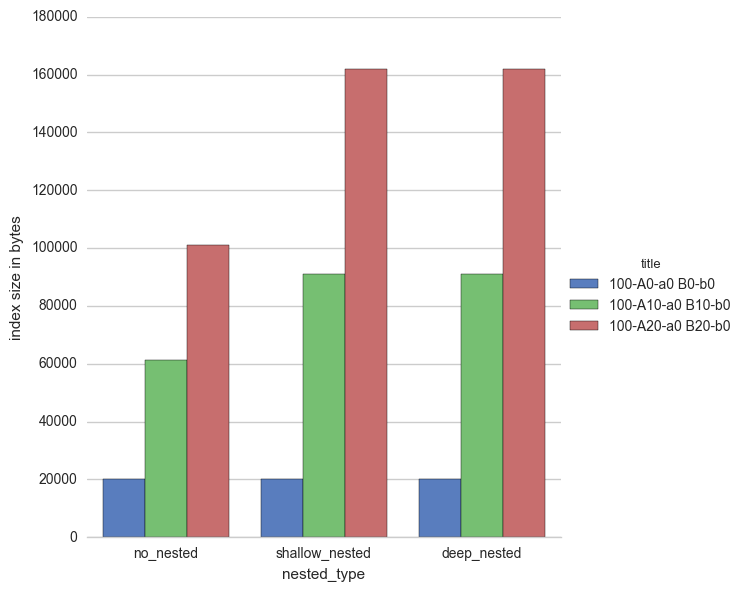

In [3]:
graph(df)

### Asnwer 1: What is the effect of two adjacent nested fields?

    ┌─────────┐      ┌───┐
    │top level├┬────⋲│ A │
    └─────────┘│     └───┘
               │
               │     ┌───┐
               └────⋲│ B │
                     └───┘

![some title](img/answer1.png)

The index size is proportional to the **sum of A and B** (orange line)

(We can also see that marking the field as not nested decreases index size linearly (blue lines)

____



### Question 2: What is the effect of a nested nested field?

    ┌─────────┐      ┌───┐      ┌───┐
    │top level├─────⋲│ A ├─────⋲│ a │
    └─────────┘      └───┘      └───┘

#### Hypotheses:

* Hypothesis 1: The difference in index size when changing the number of `a` documents from 0 to 10, and 10 to 20, will be the same. The size will be proportional to `A * a` i.e.:


      N * (d + (A * dA * a * da))


In [4]:
data = [
#     {'item_count':  100, 'item_count_a_shallow':   0, 'item_count_a_deep':   0, 'item_count_b_shallow':   0, 'item_count_b_deep':   0, 'no_nested':   20038, 'shallow_nested':   20103, 'deep_nested':   20068},
    {'item_count':  100, 'item_count_a_shallow':  10, 'item_count_a_deep':   0, 'item_count_b_shallow':   0, 'item_count_b_deep':   0, 'no_nested':   35202, 'shallow_nested':   51406, 'deep_nested':   51356},
    {'item_count':  100, 'item_count_a_shallow':  10, 'item_count_a_deep':  10, 'item_count_b_shallow':   0, 'item_count_b_deep':   0, 'no_nested':  203906, 'shallow_nested':  234086, 'deep_nested':  318818},
    {'item_count':  100, 'item_count_a_shallow':  10, 'item_count_a_deep':  20, 'item_count_b_shallow':   0, 'item_count_b_deep':   0, 'no_nested':  337642, 'shallow_nested':  378880, 'deep_nested':  520671},
#     {'item_count':  100, 'item_count_a_shallow':  20, 'item_count_a_deep':  20, 'item_count_b_shallow':   0, 'item_count_b_deep':   0, 'no_nested':  548669, 'shallow_nested':  749883, 'deep_nested':  849790},
]

df = expand(data)

df[['title', 'nested_type', 'size']]

,title,nested_type,size
0,100-A10-a0 B0-b0,no_nested,35202
1,100-A10-a0 B0-b0,shallow_nested,51406
2,100-A10-a0 B0-b0,deep_nested,51356
3,100-A10-a10 B0-b0,no_nested,203906
4,100-A10-a10 B0-b0,shallow_nested,234086
5,100-A10-a10 B0-b0,deep_nested,318818
6,100-A10-a20 B0-b0,no_nested,337642
7,100-A10-a20 B0-b0,shallow_nested,378880
8,100-A10-a20 B0-b0,deep_nested,520671


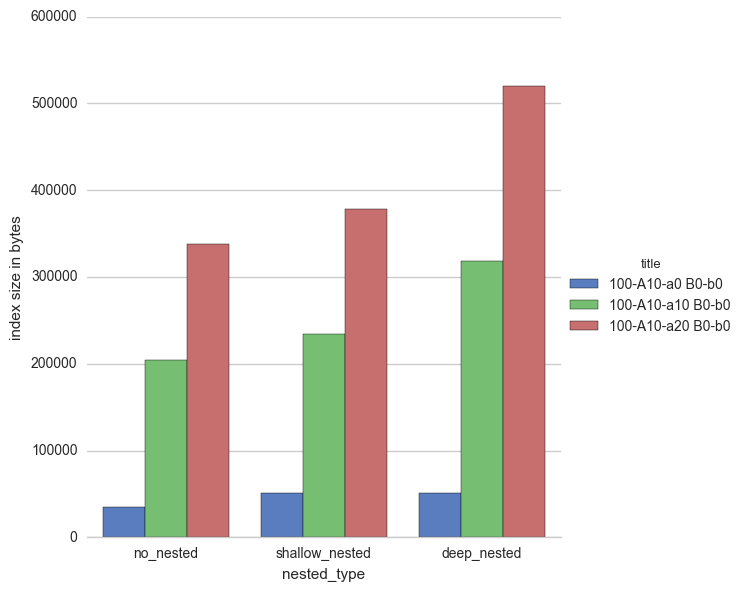

In [5]:
graph(df)

### Asnwer 2: What is the effect of a nested nested field?


    ┌─────────┐      ┌───┐      ┌───┐
    │top level├─────⋲│ A ├─────⋲│ a │
    └─────────┘      └───┘      └───┘

![some title](img/answer2.png)

The index size is proportional to the **product of A and a** (orange line)

(Interestingly it's not linear?... weird)

___

### Question 3: Can we correctly predict the effect of adjacent nested nested fields?

    ┌─────────┐      ┌───┐      ┌───┐
    │top level├┬────⋲│ A ├─────⋲│ a │
    └─────────┘│     └───┘      └───┘
               │
               │     ┌───┐      ┌───┐
               └────⋲│ B ├─────⋲│ b │
                     └───┘      └───┘

#### Hypotheses:

* Hypothesis:
    * changing A and a from 0 to 10 will result in an increase in index size of G
    * changing B and b from 0 to 10 will result in an increase in index size of H
    * then changing both A, a, B and b to 10 will result in an increase in index size of G + H, not G * H

In [6]:
data = [
    {'item_count':  100, 'item_count_a_shallow':   0, 'item_count_a_deep':   0, 'item_count_b_shallow':   0, 'item_count_b_deep':   0, 'no_nested':   20038, 'shallow_nested':   20103, 'deep_nested':   20068},
    {'item_count':  100, 'item_count_a_shallow':   10, 'item_count_a_deep':   10, 'item_count_b_shallow':   0, 'item_count_b_deep':   0, 'no_nested':   203906, 'shallow_nested':   234086, 'deep_nested':   324591},
    {'item_count':  100, 'item_count_a_shallow':   0, 'item_count_a_deep':   0, 'item_count_b_shallow':   10, 'item_count_b_deep':   10, 'no_nested':   234606, 'shallow_nested':   269908, 'deep_nested':   345520},
    {'item_count':  100, 'item_count_a_shallow':   10, 'item_count_a_deep':   10, 'item_count_b_shallow':   10, 'item_count_b_deep':   10, 'no_nested':   466875, 'shallow_nested':   529580, 'deep_nested':   811166},
]

df = expand(data)

df[['title', 'nested_type', 'size']]

,title,nested_type,size
0,100-A0-a0 B0-b0,no_nested,20038
1,100-A0-a0 B0-b0,shallow_nested,20103
2,100-A0-a0 B0-b0,deep_nested,20068
3,100-A10-a10 B0-b0,no_nested,203906
4,100-A10-a10 B0-b0,shallow_nested,234086
5,100-A10-a10 B0-b0,deep_nested,324591
6,100-A0-a0 B10-b10,no_nested,234606
7,100-A0-a0 B10-b10,shallow_nested,269908
8,100-A0-a0 B10-b10,deep_nested,345520
9,100-A10-a10 B10-b10,no_nested,466875


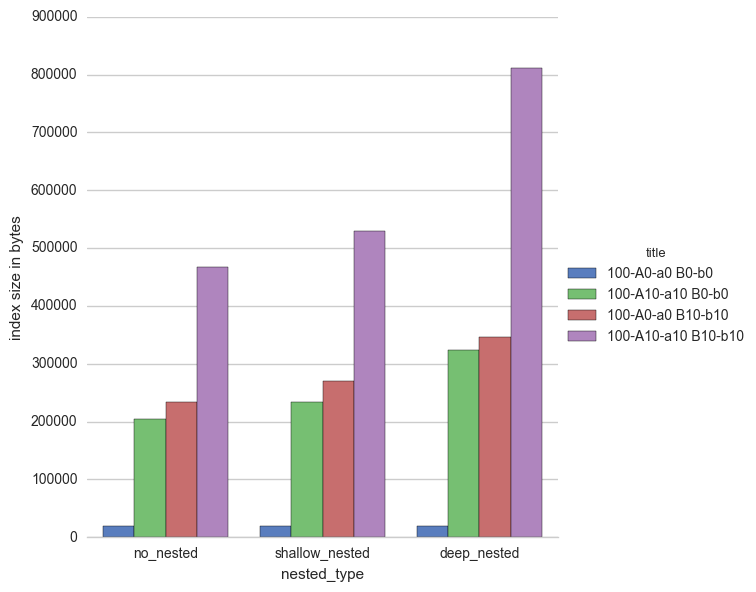

In [7]:
graph(df)

### Answer 3: Can we correctly predict the effect of adjacent nested nested fields?

    ┌─────────┐      ┌───┐      ┌───┐
    │top level├┬────⋲│ A ├─────⋲│ a │
    └─────────┘│     └───┘      └───┘
               │
               │     ┌───┐      ┌───┐
               └────⋲│ B ├─────⋲│ b │
                     └───┘      └───┘

    deep_nested 100-A0-a0 B0-b0     index size = 20068
    deep_nested 100-A10-a10 B0-b0   index size = 324591
    deep_nested 100-A0-a0 B10-b10   index size = 345520
    deep_nested 100-A10-a10 B10-b10 index size = 811166

Therefore G = 324591 - 20068 = 304523
Therefore H = 345520 - 20068 = 325452
G + H = 304523 + 325452 = 629975
And the increase from both is: 811166 - 20068 = 791098
So the increase is somewhere between G + H and G * H, but much closer towards G + H.

Conclusion: We can broadly predict effect on index size of adjacent nested nested fields but there are subtleties remaining. 